In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import re
import os
from keras.layers import LSTM,Activation,Embedding,Concatenate,Input,Dense,Activation,Dense,Flatten,RepeatVector,Reshape,Dot,RepeatVector
print(os.listdir("../input"))
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
from keras.utils.np_utils import to_categorical
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['s.txt', 'n.txt']


In [2]:
f=open("../input/n.txt")

In [3]:
text=f.read()

In [4]:
data1=text.split("\n")

In [5]:
len(data1)

189652

In [6]:
f1=open("../input/s.txt")

In [7]:
text=f1.read()

In [8]:
data2=text.split("\n")

In [9]:
data2[:5]

["injury leaves kwan 's olympic hopes in limbo",
 'us business attacks tough immigration law',
 'gm december sales fall ## percent',
 'thousands of croatians celebrate before world cup slalom',
 "laura bush <unk> rice to attend sirleaf 's inauguration in liberia"]

In [10]:
data1=data1[:50000]
data2=data2[:50000]

In [11]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [12]:
keys1=list(contractions.keys())


In [13]:
def fun1(x):
    if x in keys1:
        return contractions[x]
    return x

In [14]:
def preprocess(text):
    text=text.lower()
    text=BeautifulSoup(text,'lxml').get_text()
    text=" ".join(list(map(fun1,text.split(" "))))
    text=re.sub(r"[^\w\d]"," ",text)
    text=re.sub("\s+"," ",text)
    text=text.strip()
    return text

In [15]:
data1=[preprocess(x) for x in data1]

In [16]:
data2=[preprocess(x) for x in data2]

In [17]:
len(data1)

50000

In [18]:
Texttokenizer=Tokenizer(17400,oov_token='<unk>')
Texttokenizer.fit_on_texts(data1)

In [19]:
len1=len([k for k,v in Texttokenizer.word_counts.items() if v>2])

In [20]:
len1

17391

In [21]:
textwordindex=dict([(k,v) for k,v in Texttokenizer.word_index.items() if v<=17400])

In [22]:
textwordindex['<pad>']=0

In [23]:
textwordindex['<pad>']

0

In [24]:
tokentext=Texttokenizer.texts_to_sequences(data1)

In [25]:
texttokenpad=pad_sequences(tokentext,padding='post')

In [26]:
texttokenpad.shape

(50000, 55)

In [27]:
Sumtokenizer=Tokenizer(num_words=10080,oov_token='<unk>')
Sumtokenizer.fit_on_texts(data2)

In [28]:
len2=len([k for k,v in Sumtokenizer.word_counts.items() if v>2])

In [29]:
len2

10074

In [30]:
sumtoken=Sumtokenizer.texts_to_sequences(data2)

In [31]:
sumtokenpad=pad_sequences(sumtoken,padding='post')

In [32]:
h=set()
for i in range(len(sumtoken)):
    h.update(sumtokenpad[i])

In [33]:
len(h)

10080

In [34]:
sumwordindex=dict([(k,v) for k,v in Sumtokenizer.word_index.items() if v<=10080])

In [35]:
sumwordindex['<pad>']=0

In [36]:
len(sumwordindex)

10081

In [37]:
len(textwordindex)

17401

In [38]:
texttokenpad.shape

(50000, 55)

In [39]:
sumtokenpad.shape

(50000, 22)

In [40]:
Tx=texttokenpad.shape[1]
Ty=sumtokenpad.shape[1]

In [41]:
densor=Dense(64,activation='relu')
densor1=Dense(1,activation='relu')
repeat=RepeatVector(Tx)
activator=Activation('softmax')
dotor=Dot(axes=1)

In [42]:
def one_step_attention(a,st_prev):
    st_prev1=repeat(st_prev)  # m X Tx X n_s
    concat=Concatenate(axis=-1)([a,st_prev1])
    dens=densor(concat)
    dens1=densor1(dens)  #weights for attention  m X Tx
    dens2=activator(dens1)
    context=dotor([dens2,a])
    
    return context

In [43]:
n_a=256
n_s=256
post_activation_lstm=LSTM(n_s,return_state=True)
outputlayer=Dense(len(sumwordindex),activation='softmax')

In [44]:
x=Input(shape=(Tx,))
embed=Embedding(len(textwordindex),32,input_length=Tx,)(x)

In [45]:
s0=Input(shape=(n_s,))
c0=Input(shape=(n_s,))
s=s0
c=c0

In [46]:
outputs=[]
a=LSTM(n_a,return_sequences=True)(embed)

In [47]:
for i in range(Ty):
    context=one_step_attention(a,s)
    s,_,c=post_activation_lstm(context,initial_state=[s,c])
    
    out=outputlayer(s)
    outputs.append(out)
    
model=Model(inputs=[x,s0,c0],outputs=outputs)

In [48]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 55)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 55, 32)       556832      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 55, 256)      295936      embedding_1[0][0]                
__________________________________________________________________________________________________
repeat_vec

In [49]:

model.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

In [50]:
m=len(texttokenpad)

In [51]:
s01=np.zeros((m,n_s))
c01=np.zeros((m,n_s))

In [52]:
len(sumwordindex)

10081

In [53]:
texttokenpad.shape

(50000, 55)

In [54]:
def generator(x1=texttokenpad,y1=sumtokenpad,batchsize=256):
    while True:
        
        s01=np.zeros((batchsize,n_s))
        c01=np.zeros((batchsize,n_s))
        m=np.random.choice(50000,size=batchsize,replace=False)
        batch_x=x1[m]
        batch_y=y1[m]
        batch_y=to_categorical(batch_y,len(sumwordindex))
        yield ([batch_x,s01,c01],list(batch_y.swapaxes(0,1)))
        
        

In [55]:
history=model.fit_generator(generator(),steps_per_epoch=1000,epochs=50,verbose=1)


Epoch 1/50
1000/1000 [==============================] - 673s 673ms/step - loss: 73.0159 - dense_3_loss: 0.4728 - dense_3_acc: 0.0000e+00 - dense_3_acc_1: 0.0000e+00 - dense_3_acc_2: 7.0703e-04 - dense_3_acc_3: 0.0056 - dense_3_acc_4: 0.0464 - dense_3_acc_5: 0.1308 - dense_3_acc_6: 0.2648 - dense_3_acc_7: 0.4385 - dense_3_acc_8: 0.6233 - dense_3_acc_9: 0.7903 - dense_3_acc_10: 0.9003 - dense_3_acc_11: 0.9604 - dense_3_acc_12: 0.9849 - dense_3_acc_13: 0.9936 - dense_3_acc_14: 0.9968 - dense_3_acc_15: 0.9977 - dense_3_acc_16: 0.9985 - dense_3_acc_17: 0.9987 - dense_3_acc_18: 0.9989 - dense_3_acc_19: 0.9989 - dense_3_acc_20: 0.9989 - dense_3_acc_21: 0.9990
Epoch 2/50
1000/1000 [==============================] - 652s 652ms/step - loss: 71.8098 - dense_3_loss: 0.3984 - dense_3_acc: 0.0000e+00 - dense_3_acc_1: 0.0000e+00 - dense_3_acc_2: 6.7578e-04 - dense_3_acc_3: 0.0059 - dense_3_acc_4: 0.0469 - dense_3_acc_5: 0.1321 - dense_3_acc_6: 0.2671 - dense_3_acc_7: 0.4375 - dense_3_acc_8: 0.6245 - 

In [56]:
trainloss=history.history['loss']

In [57]:
trainacc=history.history['acc']

KeyError: 'acc'

In [58]:
import matplotlib.pyplot as plt


In [59]:
plt.plot(trainacc)

NameError: name 'trainacc' is not defined

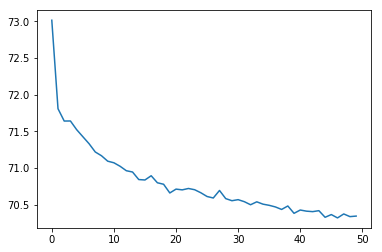

In [60]:
plt.plot(trainloss)